In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import plotly.express as px  
import plotly.graph_objects as go  
import math
from plotly.subplots import make_subplots 


## **Goal of the Project**

Employee attrition has major financial and operational impacts on organizations. 

This project will takes a two-step approach to understand and address attrition:

Employee Segmentation (Clustering): Group employees into meaningful clusters.
Attrition Prediction (Classification): Predict whether an employee is likely to leave.

This combination helps HR teams not only identify who is at risk but also why certain groups are more vulnerable, enabling targeted interventions.


## **1. EDA of the raw data**

In [2]:
#create our dataframe 
employee_df=pd.read_csv('/Users/vivian/Documents/people_analytics/employee_data.csv')
employee_df.head()

,EmployeeID,Age,Gender,DistanceFromHome,JobLevel,Department,MonthlyIncome,PerformanceRating,JobSatisfaction,Attrition
0,1001,41,Female,1,2,Sales,5993,3,4,Yes
1,1002,49,Male,8,2,Research & Development,5130,4,2,No
2,1004,37,Male,2,1,Research & Development,2090,3,3,Yes
3,1005,33,Female,3,1,Research & Development,2909,3,3,No
4,1007,27,Male,2,1,Research & Development,3468,3,2,No


In [3]:
#create a copy of the original data frame 
df=employee_df.copy()
df.shape

(1470, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   EmployeeID         1470 non-null   int64 
 1   Age                1470 non-null   int64 
 2   Gender             1470 non-null   object
 3   DistanceFromHome   1470 non-null   int64 
 4   JobLevel           1470 non-null   int64 
 5   Department         1470 non-null   object
 6   MonthlyIncome      1470 non-null   int64 
 7   PerformanceRating  1470 non-null   int64 
 8   JobSatisfaction    1470 non-null   int64 
 9   Attrition          1470 non-null   object
dtypes: int64(7), object(3)
memory usage: 115.0+ KB


In [5]:
df.dtypes[df.dtypes == 'object']

Gender        object
Department    object
Attrition     object
dtype: object

In [6]:
#creating dummy variable for the categorical data and assign binary answers values 1 and 0, for gender I assign Female 1 and male 0.
df.Gender=np.where(df.Gender =='Female',1,0)
df.Gender.head()

0    1
1    0
2    0
3    1
4    0
Name: Gender, dtype: int64

In [7]:
#Attrition yes assgined the value of 1 and no is 0.
df.Attrition = np.where(df.Attrition =='Yes', 1, 0)
df.Attrition.head()

0    1
1    0
2    1
3    0
4    0
Name: Attrition, dtype: int64

In [8]:
from scipy.stats import chi2_contingency


# Keep a small frame with just the columns we need
df_cat = df[['Gender', 'Department', 'Attrition']].copy()

# Build chi-square for each categorical column vs Attrition
results = []
for col in ['Gender', 'Department']:
    ct = pd.crosstab(df_cat[col], df_cat['Attrition'])   # frequency table
    chi2_stat, p, dof, expected = chi2_contingency(ct)
    results.append((col, chi2_stat, p))

chi2_df = pd.DataFrame(results, columns=['Feature', 'Chi2 Score', 'p-value']) \
            .sort_values('Chi2 Score', ascending=False)

print(chi2_df)


      Feature  Chi2 Score   p-value
1  Department   10.796007  0.004526
0      Gender    1.116967  0.290572


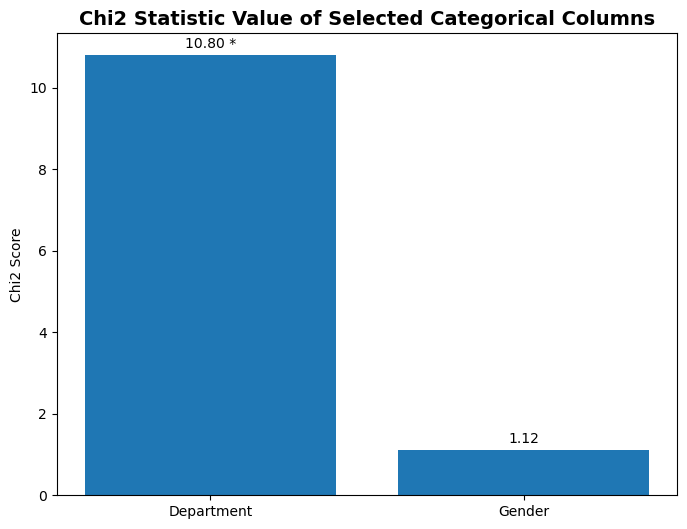

FileNotFoundError: [Errno 2] No such file or directory: '/Users/vivian/outputs/chi_square.png'

<Figure size 640x480 with 0 Axes>

In [50]:
plt.figure(figsize=(8,6))
bars = plt.bar(chi2_df['Feature'], chi2_df['Chi2 Score'])

# label bars and add a quick significance tag
for i, bar in enumerate(bars):
    yval = bar.get_height()
    sig = ' *' if chi2_df.iloc[i]['p-value'] < 0.05 else ''
    plt.text(bar.get_x()+bar.get_width()/2, yval+0.1,
             f"{yval:.2f}{sig}", ha='center', va='bottom')

plt.title("Chi2 Statistic Value of Selected Categorical Columns", fontsize=14, fontweight='bold')
plt.ylabel("Chi2 Score")
plt.xticks(rotation=0)
plt.show()
plt.savefig("outputs/chi_square.png", dpi=300, bbox_inches="tight")


In [10]:
from scipy import stats

# Make sure Attrition is 0/1
df["Attrition"] = df["Attrition"].replace({"No": 0, "Yes": 1})

# Select numeric columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop("Attrition")

anova_results = []
for col in num_cols:
    # Split the numeric column into two groups: stay (0) vs leave (1)
    group0 = df[df["Attrition"] == 0][col]
    group1 = df[df["Attrition"] == 1][col]

    # Run one-way ANOVA
    f_stat, p_val = stats.f_oneway(group0, group1)
    anova_results.append((col, f_stat, p_val))

# Put into DataFrame
anova_df = pd.DataFrame(anova_results, columns=["Feature", "F-Score", "p-value"]) \
             .sort_values(by="F-Score", ascending=False)

print(anova_df)


             Feature    F-Score       p-value
4           JobLevel  43.215344  6.795385e-11
5      MonthlyIncome  38.488819  7.147364e-10
1                Age  38.175887  8.356308e-10
7    JobSatisfaction  15.890004  7.043067e-05
3   DistanceFromHome   8.968277  2.793060e-03
2             Gender   1.274587  2.590924e-01
0         EmployeeID   0.164255  6.853276e-01
6  PerformanceRating   0.012250  9.118840e-01


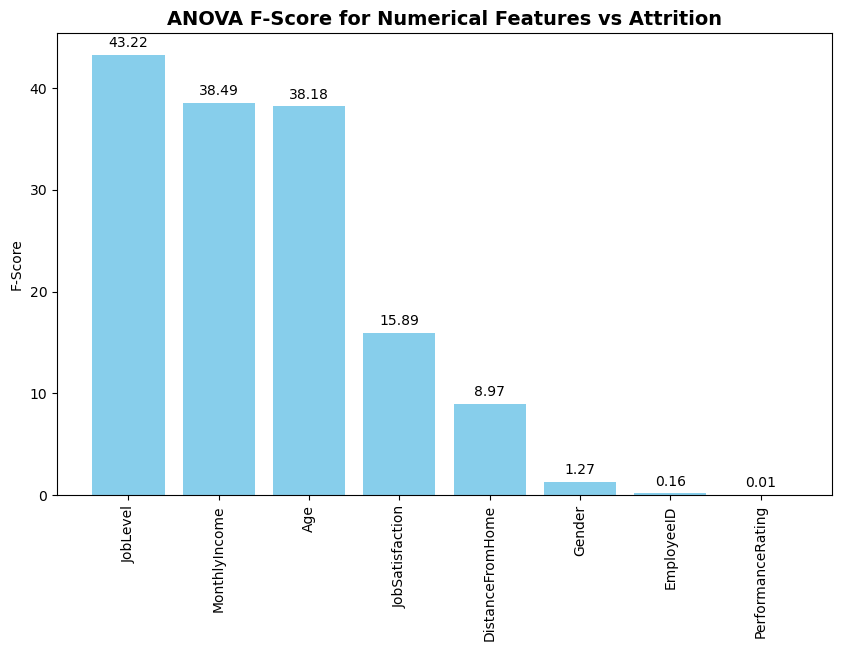

In [11]:
plt.figure(figsize=(10,6))
bars = plt.bar(anova_df["Feature"], anova_df["F-Score"], color="skyblue")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha="center", va="bottom")

plt.title("ANOVA F-Score for Numerical Features vs Attrition", fontsize=14, fontweight="bold")
plt.ylabel("F-Score")
plt.xticks(rotation=90)
plt.show()


**At this point, it looks like Strong predictors are JobLevel, MonthlyIncome, Age, JobSatisfaction, DistanceFromHome, Department. We'll drop Weak predictors like Gender, PerformanceRating and EmployeeID**

In [12]:
df_Department = pd.get_dummies(df.Department).astype('int')
df =pd.concat([df,df_Department],axis = 1).drop(["EmployeeID", "Department","Gender","PerformanceRating"], axis = 1)
df.head()

,Age,DistanceFromHome,JobLevel,MonthlyIncome,JobSatisfaction,Attrition,Human Resources,Research & Development,Sales
0,41,1,2,5993,4,1,0,0,1
1,49,8,2,5130,2,0,0,1,0
2,37,2,1,2090,3,1,0,1,0
3,33,3,1,2909,3,0,0,1,0
4,27,2,1,3468,2,0,0,1,0


In [13]:
attrition_counts = df.Attrition.value_counts()
attrition_ratio =df.Attrition.mean()

print(attrition_counts, attrition_ratio)

Attrition
0    1233
1     237
Name: count, dtype: int64 0.16122448979591836


In [14]:
#Comparing employees who stay (0) vs. who leave (1)
df.groupby('Attrition').mean()

,Age,DistanceFromHome,JobLevel,MonthlyIncome,JobSatisfaction,Human Resources,Research & Development,Sales
Attrition,,,,,,,,
0,37.561233,8.915653,2.145985,6832.739659,2.778589,0.041363,0.671533,0.287105
1,33.607595,10.632911,1.637131,4787.092827,2.468354,0.050633,0.561181,0.388186


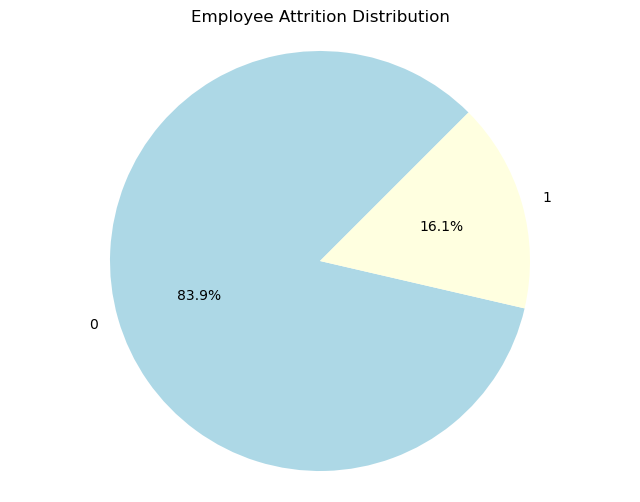

In [15]:
plt.figure(figsize=(8, 6))
plt.pie(attrition_counts, labels=attrition_counts.index, autopct='%1.1f%%', startangle=45, colors=['lightblue', 'lightyellow'])
plt.title('Employee Attrition Distribution')
plt.axis('equal')
plt.show()

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.0,36.0,43.0,60.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.0,7.0,14.0,29.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.0,2.0,3.0,5.0
MonthlyIncome,1470.0,6502.931293,4707.956783,1009.0,2911.0,4919.0,8379.0,19999.0
JobSatisfaction,1470.0,2.728571,1.102846,1.0,2.0,3.0,4.0,4.0
Attrition,1470.0,0.161224,0.367863,0.0,0.0,0.0,0.0,1.0
Human Resources,1470.0,0.042857,0.202604,0.0,0.0,0.0,0.0,1.0
Research & Development,1470.0,0.653741,0.475939,0.0,0.0,1.0,1.0,1.0
Sales,1470.0,0.303401,0.459884,0.0,0.0,0.0,1.0,1.0


In [17]:
df.shape

(1470, 9)

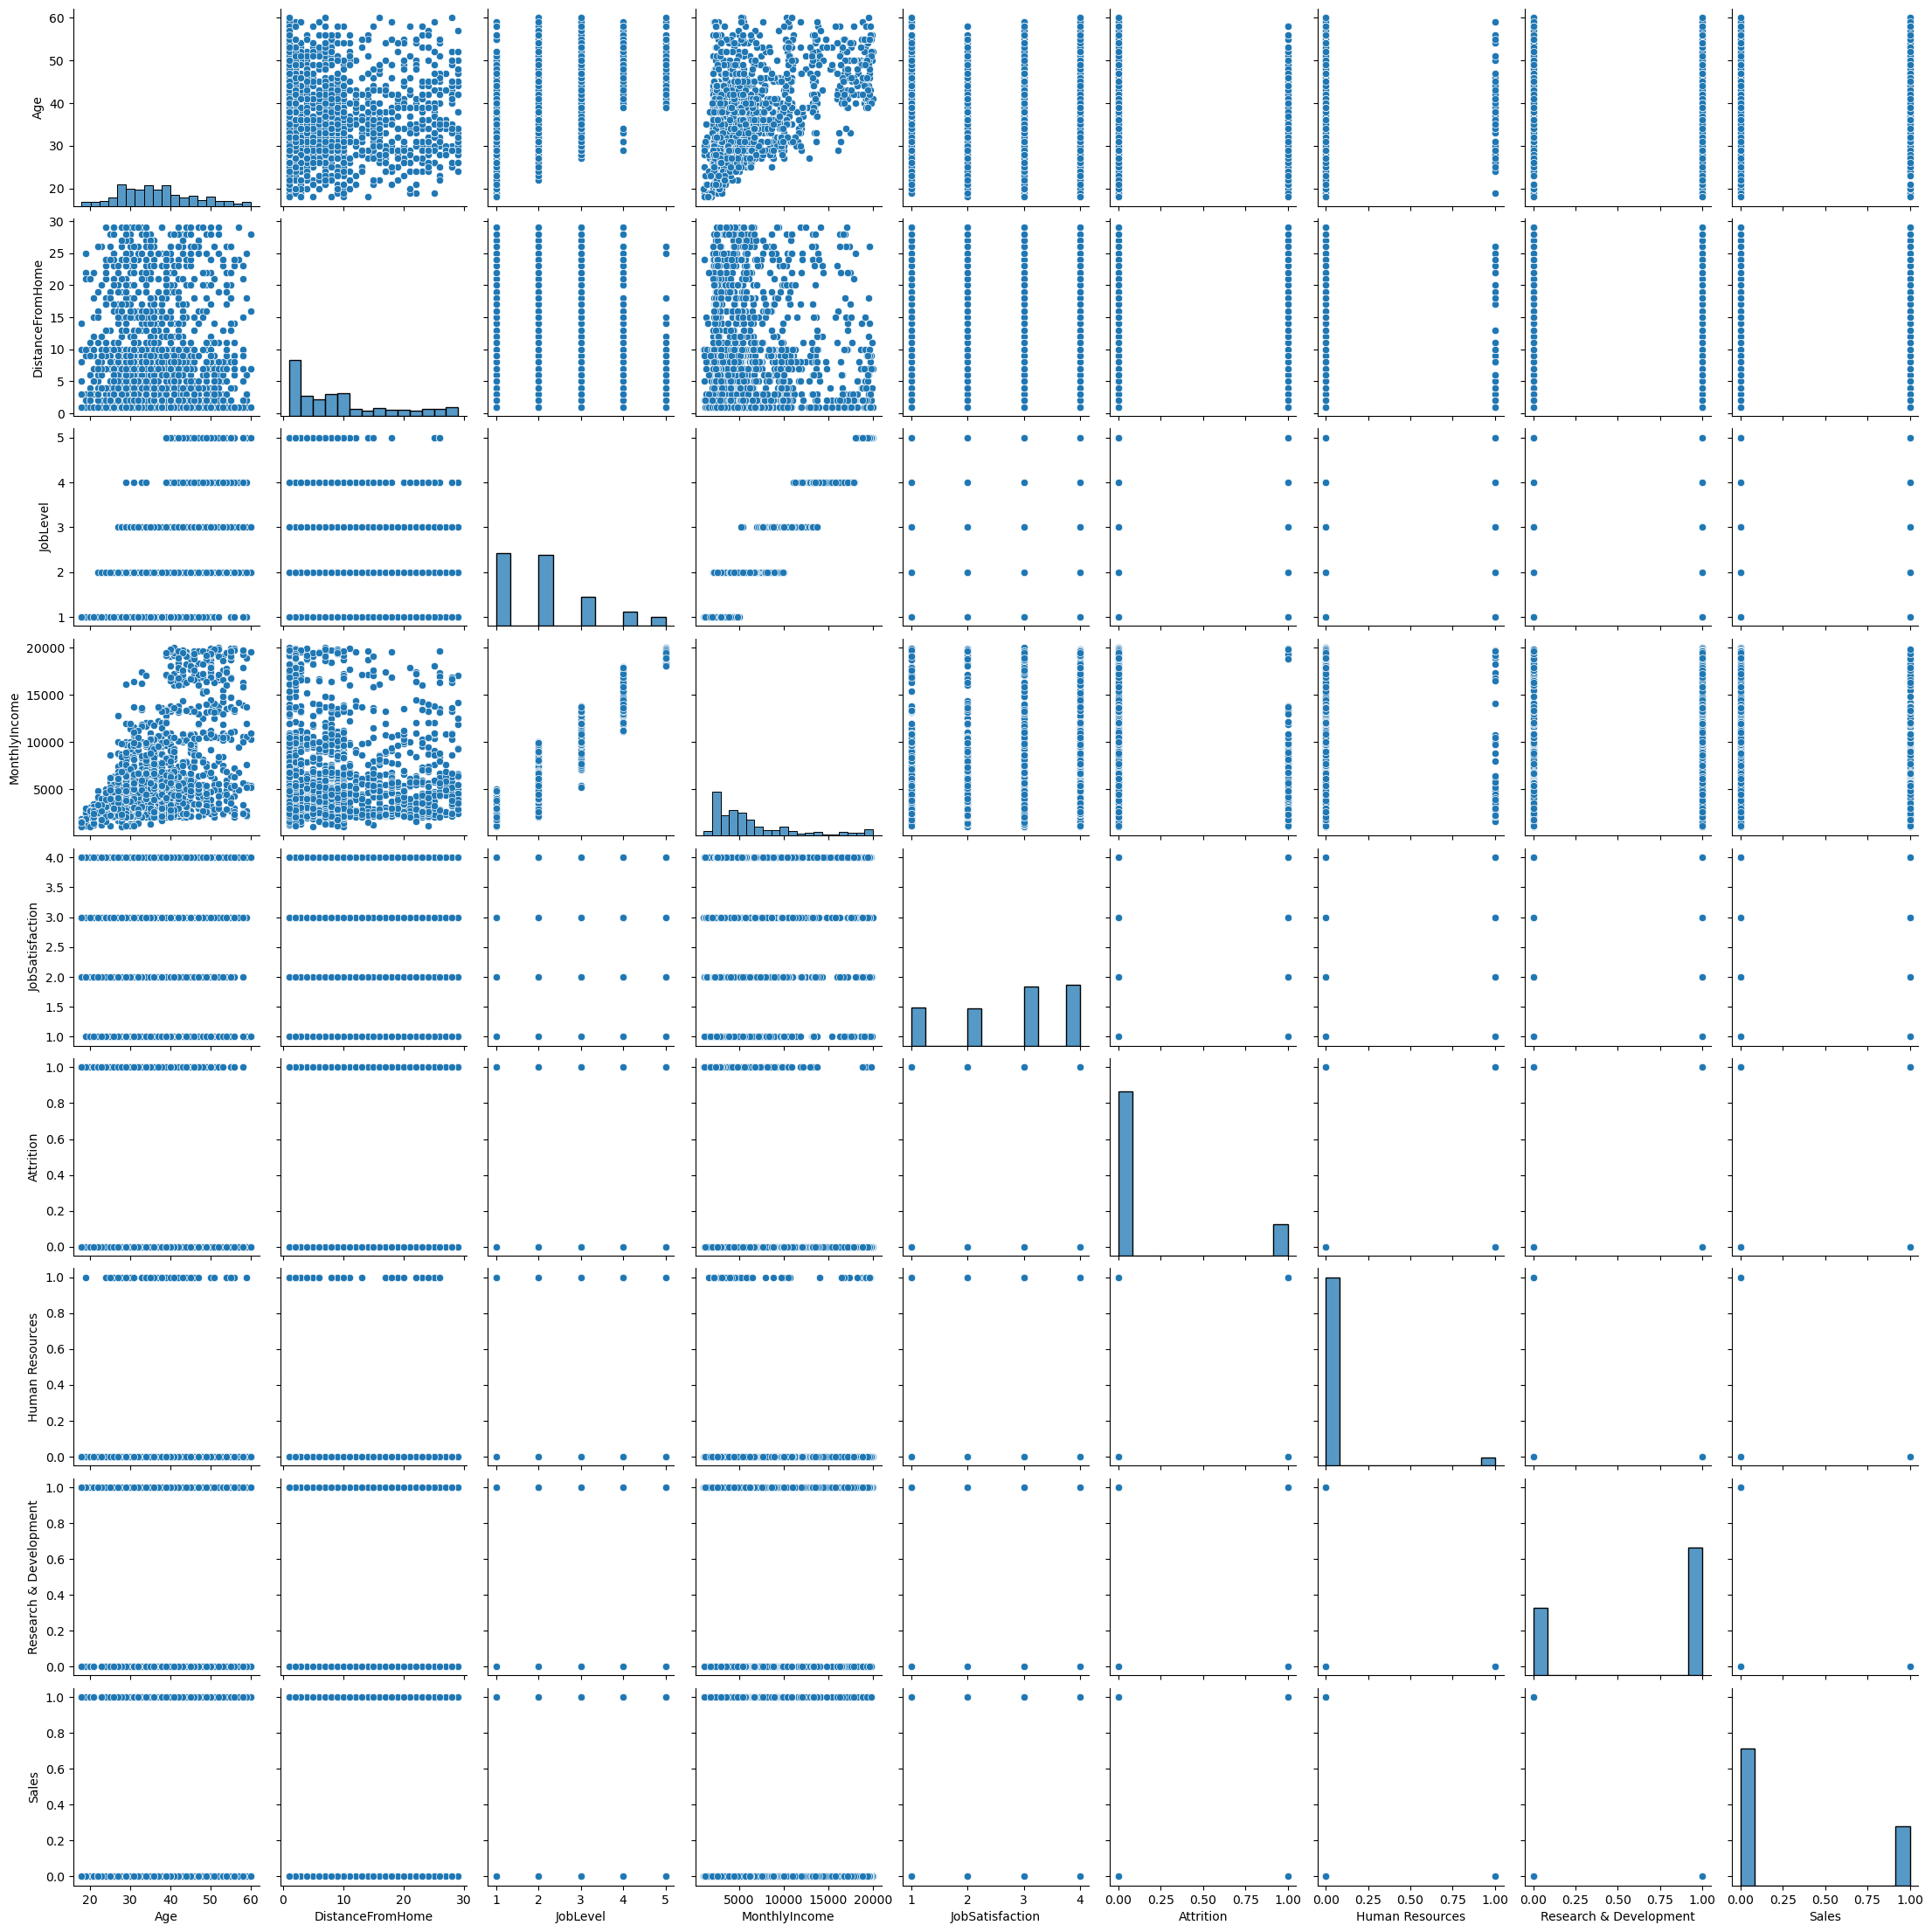

In [18]:
sns.pairplot(df);

## **People Segmentation** 

**Using Kmean & DBSCAN to segment employees**

In [19]:
#Drop EmployeeID and Attrition columns to start the modeling process
df = df.drop(['Attrition'],axis = 1)
df.head()

,Age,DistanceFromHome,JobLevel,MonthlyIncome,JobSatisfaction,Human Resources,Research & Development,Sales
0,41,1,2,5993,4,0,0,1
1,49,8,2,5130,2,0,1,0
2,37,2,1,2090,3,0,1,0
3,33,3,1,2909,3,0,1,0
4,27,2,1,3468,2,0,1,0


In [20]:
#Scale the dataframe
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_scaled.head()

,Age,DistanceFromHome,JobLevel,MonthlyIncome,JobSatisfaction,Human Resources,Research & Development,Sales
0,0.446350,-1.010909,-0.057788,-0.108350,1.153254,-0.211604,-1.374051,1.515244
1,1.322365,-0.147150,-0.057788,-0.291719,-0.660853,-0.211604,0.727775,-0.659960
2,0.008343,-0.887515,-0.961486,-0.937654,0.246200,-0.211604,0.727775,-0.659960
3,-0.429664,-0.764121,-0.961486,-0.763634,0.246200,-0.211604,0.727775,-0.659960
4,-1.086676,-0.887515,-0.961486,-0.644858,-0.660853,-0.211604,0.727775,-0.659960


In [21]:
df_scaled.describe()

,Age,DistanceFromHome,JobLevel,MonthlyIncome,JobSatisfaction,Human Resources,Research & Development,Sales
count,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03
mean,-3.504377e-17,4.350262e-17,-2.658493e-17,-4.471102e-17,-9.183886e-17,6.767074e-17,2.900174e-17,8.458842e-17
std,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00
min,-2.072192e+00,-1.010909e+00,-9.614864e-01,-1.167343e+00,-1.567907e+00,-2.116037e-01,-1.374051e+00,-6.599598e-01
25%,-7.581700e-01,-8.875151e-01,-9.614864e-01,-7.632087e-01,-6.608532e-01,-2.116037e-01,-1.374051e+00,-6.599598e-01
50%,-1.011589e-01,-2.705440e-01,-5.778755e-02,-3.365516e-01,2.462002e-01,-2.116037e-01,7.277751e-01,-6.599598e-01
75%,6.653541e-01,5.932157e-01,8.459113e-01,3.986245e-01,1.153254e+00,-2.116037e-01,7.277751e-01,1.515244e+00
max,2.526886e+00,2.444129e+00,2.653309e+00,2.867626e+00,1.153254e+00,4.725816e+00,7.277751e-01,1.515244e+00


In [22]:
#fitting the models with 2 to 15 clusters
inertia_values = []
silhouette_scores = []

for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_, metric='euclidean',sample_size = None))


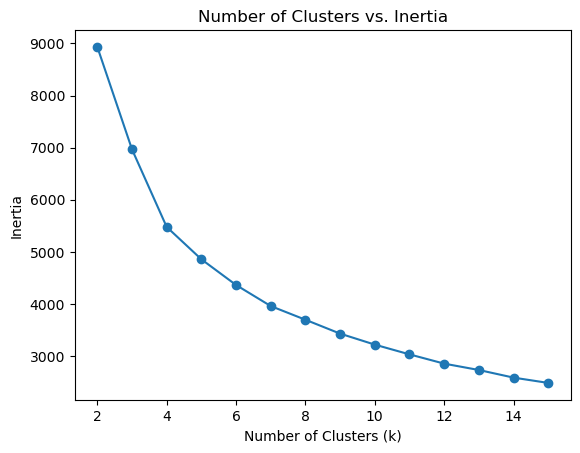

In [23]:
#Plot the inertia values

inertia_series = pd.Series(inertia_values, index = range(2,16))

inertia_series.plot(marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Number of Clusters vs. Inertia");

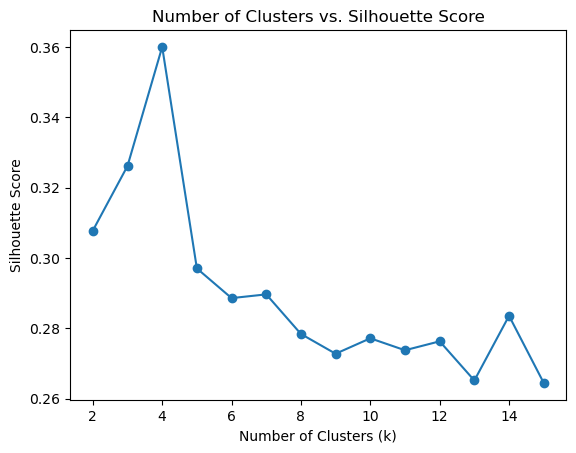

In [24]:
silhouette_series = pd.Series(silhouette_scores, index=range(2,16))
silhouette_series.plot(marker = 'o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Number of Clusters vs. Silhouette Score");


In [25]:
#comparing inertia scores and silhouette scores, we arrived at 4 clusters to buildl our model
kmeans4 = KMeans(n_clusters = 4, n_init = 10, random_state = 42)
kmeans4.fit(df_scaled)

KMeans(n_clusters=4, n_init=10, random_state=42)

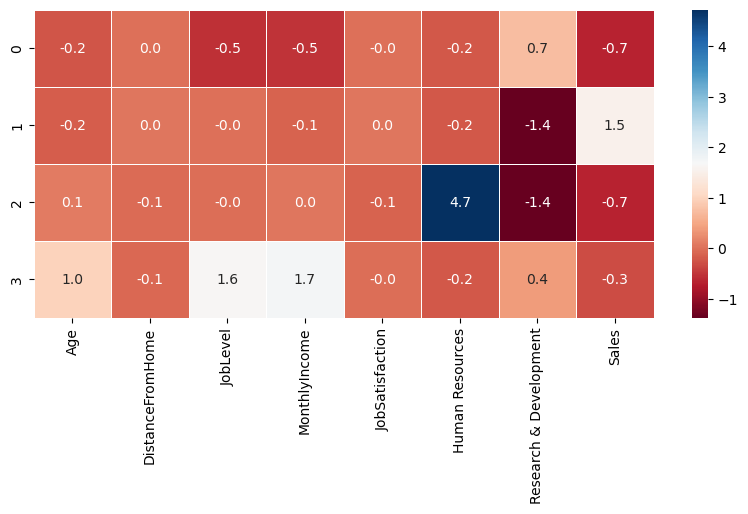

In [26]:
cluster_centers_4 = pd.DataFrame(kmeans4.cluster_centers_,columns = df_scaled.columns)
plt.figure(figsize = (10,4))
sns.heatmap(cluster_centers_4, annot = True, cmap="RdBu", fmt=".1f", linewidths=.5);

In [27]:
pca = PCA(n_components = 2)
pca.fit(df_scaled)

PCA(n_components=2)

In [28]:
pca.explained_variance_ratio_

array([0.29689595, 0.2358411 ])

In [29]:
pca.components_

array([[ 0.43404198, -0.00247832,  0.60636757,  0.59597074, -0.00357629,
         0.03078005, -0.21254511,  0.20640506],
       [ 0.21193754, -0.01780763,  0.14302665,  0.17499445, -0.01181894,
        -0.11430257,  0.68043169, -0.65382998]])

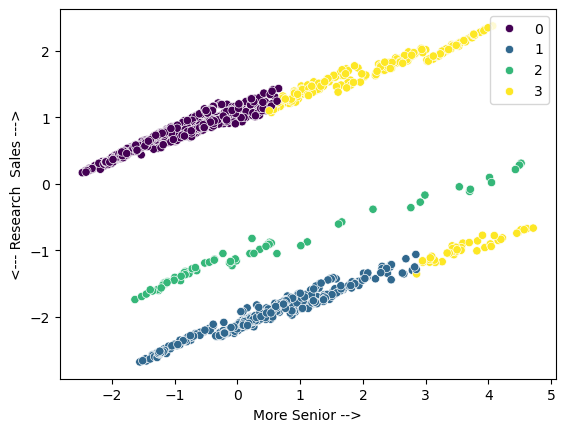

In [30]:
df_scaled_transformed = pd.DataFrame(pca.transform(df_scaled), columns =['PC1','PC2'])
sns.scatterplot(x='PC1', y='PC2', data=df_scaled_transformed,hue=kmeans4.labels_,palette='viridis')
plt.xlabel('More Senior -->')
plt.ylabel('<--- Research  Sales --->')
plt.legend(loc='upper right');
                                                                         

**The clusters didn't turn out the way I want. Looking at PC2, it looks like the Department data is dominating the clusters.**

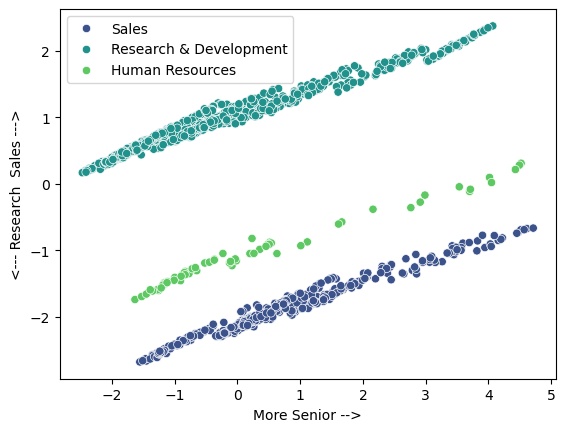

In [35]:
df_scaled_transformed = pd.DataFrame(pca.transform(df_scaled), columns =['PC1','PC2'])
sns.scatterplot(x='PC1', y='PC2', data=df_scaled_transformed,hue=employee_df['Department'],palette='viridis')
plt.xlabel('More Senior -->')
plt.ylabel('<--- Research  Sales --->')
plt.legend(loc = 'upper left');

# **I want to repeat Kmean analysis by dropping Department data to see if I can get better signals**

In [39]:
#drop the last 3 columns of the df_scaled
df_scaled_v2 = df_scaled.iloc[:, :5]
df_scaled_v2.head()

,Age,DistanceFromHome,JobLevel,MonthlyIncome,JobSatisfaction
0,0.446350,-1.010909,-0.057788,-0.108350,1.153254
1,1.322365,-0.147150,-0.057788,-0.291719,-0.660853
2,0.008343,-0.887515,-0.961486,-0.937654,0.246200
3,-0.429664,-0.764121,-0.961486,-0.763634,0.246200
4,-1.086676,-0.887515,-0.961486,-0.644858,-0.660853


In [41]:
#fitting the models with 2 to 15 clusters again
inertia_values2 = []
silhouette_scores2 = []

for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(df_scaled_v2)
    inertia_values2.append(kmeans.inertia_)
    silhouette_scores2.append(silhouette_score(df_scaled_v2, kmeans.labels_, metric='euclidean',sample_size = None))

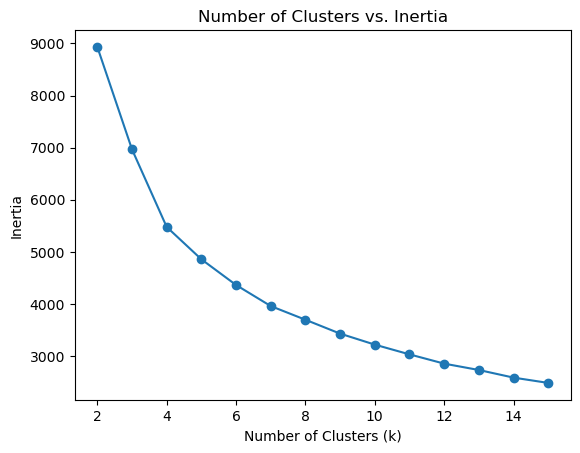

In [42]:
#Plot the inertia values

inertia_series2 = pd.Series(inertia_values2, index = range(2,16))

inertia_series.plot(marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Number of Clusters vs. Inertia");

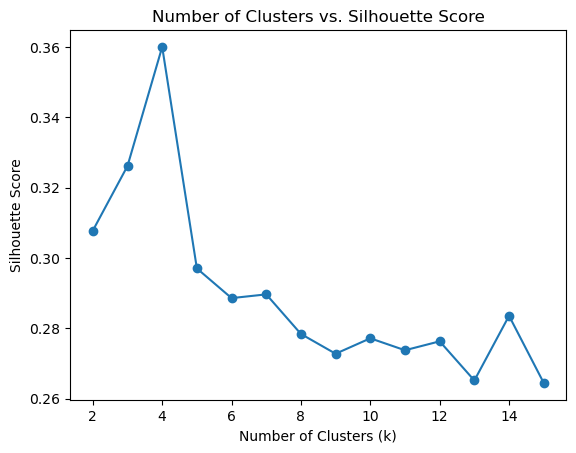

In [43]:
silhouette_series2 = pd.Series(silhouette_scores2, index=range(2,16))
silhouette_series.plot(marker = 'o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Number of Clusters vs. Silhouette Score");

In [46]:
#comparing inertia scores and silhouette scores, we arrived at 4 clusters to buildl our model
kmeans4_v2 = KMeans(n_clusters = 4, n_init = 10, random_state = 42)
kmeans4_v2.fit(df_scaled_v2)

KMeans(n_clusters=4, n_init=10, random_state=42)

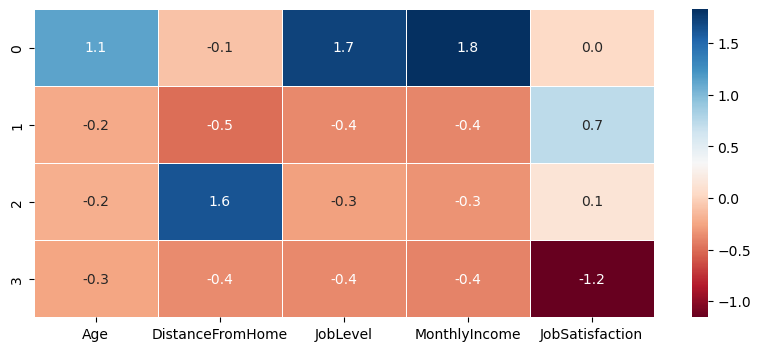

In [47]:
cluster_centers4_v2 = pd.DataFrame(kmeans4_v2.cluster_centers_,columns = df_scaled_v2.columns)
plt.figure(figsize = (10,4))
sns.heatmap(cluster_centers4_v2, annot = True, cmap="RdBu", fmt=".1f", linewidths=.5);

## Cluster Interpretation

After running KMeans with 4 clusters on the HR dataset (features: Age, DistanceFromHome, JobLevel, MonthlyIncome, JobSatisfaction), we interpret the clusters as follows:

### **Cluster 0 – Senior & Stable**
- **Older** than average employees  
- **Higher JobLevel & MonthlyIncome** (well-paid, more senior)  
- **Closer commute** than average  
- **JobSatisfaction ~ average**  
Likely **low attrition risk**, experienced, stable group.

---

### **Cluster 1 – Early Career but Satisfied**
- **Younger**, **lower level**, and **lower income**  
- **Closer commute** than average  
- **Higher JobSatisfaction**  
Entry-level employees who are relatively **content** despite lower pay.

---

### **Cluster 2 – Commute Risk Group**
- **Lives much farther** than average from the office  
- **JobLevel, Income ~ average**  
- **JobSatisfaction slightly below average**  
Commute distance could be a **driver of attrition risk**.

---

### **Cluster 3 – Disengaged & Dissatisfied**
- **Younger**, **lower level**, **lower income**  
- **Much lower JobSatisfaction**  
- Commute slightly shorter than average  
Employees most likely to be **at risk of attrition** due to dissatisfaction.

---


In [49]:
#Check cluster size and Attrition_Rate
employee_df['Cluster'] = kmeans4.labels_

# Now you can summarize
cluster_summary = employee_df.groupby('Cluster').agg(
    Employees=('Attrition', 'count'),
    Attrition_Rate=('Attrition', lambda x: (x == "Yes").mean())
).reset_index()

print(cluster_summary)



   Cluster  Employees  Attrition_Rate
0        0        254        0.082677
1        1        554        0.138989
2        2        273        0.227106
3        3        389        0.197943


**The summary indicates cluster 2 and 3 are at risk of attrition**